In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('test_ml.txt', sep="\t")


Посмотрим на информативность признаков и степень их заполненности.

In [6]:
print('if there are any null data: ', data.isnull().values.any())

info = data[data!=0].count()/(len(data))*100
little_info_cols = list(info[info<5].dropna().index)

print('these columns are not very informative: ', little_info_cols)

if there are any null data:  False
these columns are not very informative:  ['x2', 'x3', 'x4', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x19', 'x20', 'x24', 'x25']


Теперь можно посмотреть на таблички взаимных корреляций столбцов. Спасибо seaborn за удобную визуализацию. :)

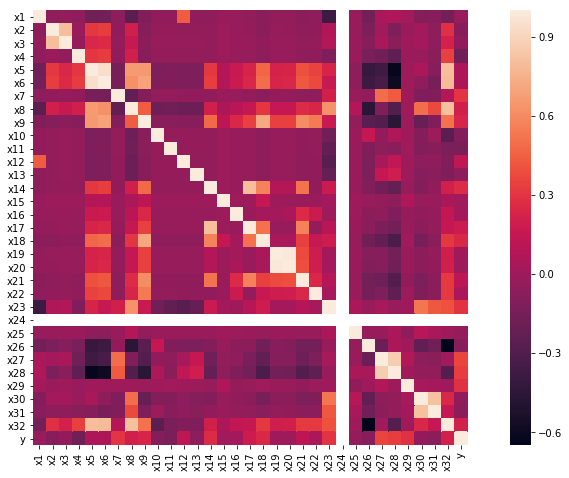

In [15]:
corrmat_full = data.corr()
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corrmat_full, square=True);

In [10]:
print(data.x24.abs().sum())

0.0


Видно, что есть несколько сильноскоррелированных признаков, а еще x24, который вообще состоит из нулей.

In [17]:
data = data.drop('x24', axis = 1).dropna()

Все-таки посмотрим отдельно на те признаки, у которых очень мало отличных от нуля значений. У них может быть приличная корреляция с целевой переменной. 
Если уж пытаться отбирать существенные признаки, то проверить - не лишнее.

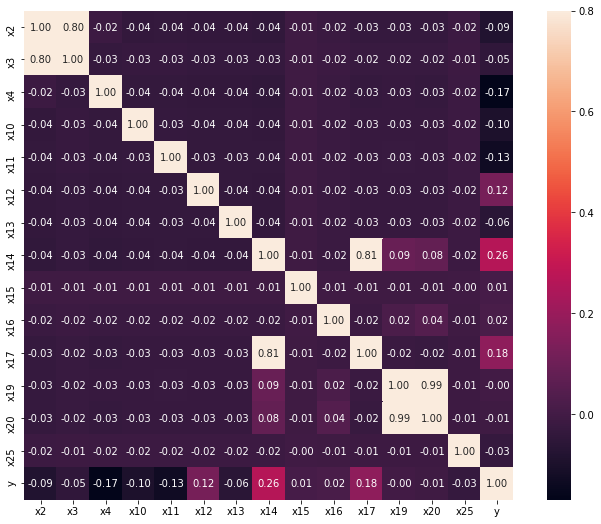

In [19]:
little_info_cols.remove('x24')
cols = np.append(little_info_cols, 'y')
corrmat_info = data[cols].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_info, annot=True, fmt='.2f', vmax=.8, square=True);

Это коррелиционная матрица столбцов, у которых ненулевые <5% значений.
Похоже, что единственныхм, который можно было бы взять - это х14.

А еще посмотрим на корреляционную матрицу и увидим, у каких признаков наибольшая корреляция с целевой переменной.

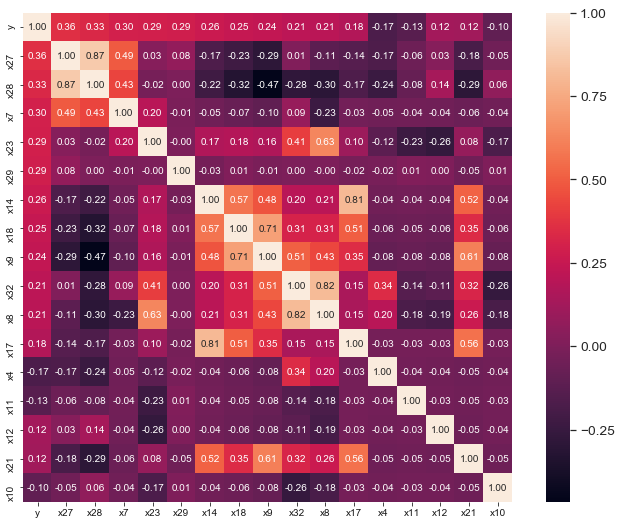

In [20]:
corrmat = data.corr().abs()
k = 17 #number of variables for heatmap
cols = corrmat.nlargest(k, 'y')['y'].index
cm = np.corrcoef(data[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Если отбирать признаки, то отсюда явно нет смысла брать х27 и х28 одновременно. 
Так же стоит задуматься про х18 и х9.

In [21]:
columns = list(cols)
columns.remove('x28')
columns.remove('y')

print(columns)

['x27', 'x7', 'x23', 'x29', 'x14', 'x18', 'x9', 'x32', 'x8', 'x17', 'x4', 'x11', 'x12', 'x21', 'x10']


In [22]:
df_chosen = data[columns]
y = data.y

А теперь не мешает посмотреть на то, как выглядят распределения наших признаков.
Возможно станет понятнее, что делать дальше.

x1


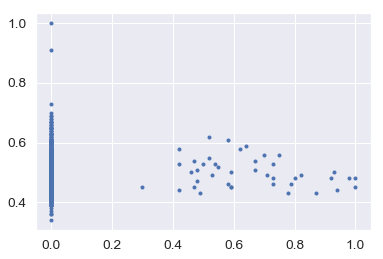

x2


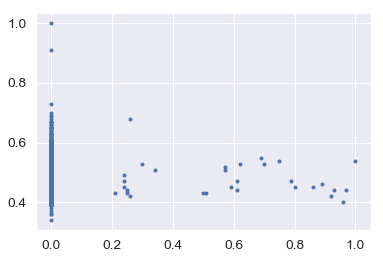

x3


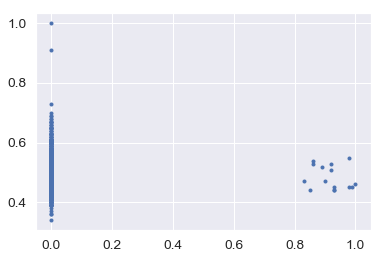

x4


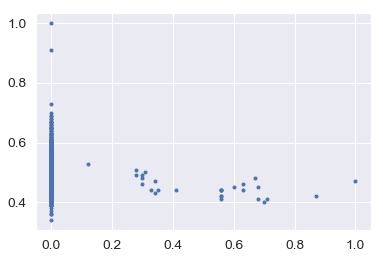

x5


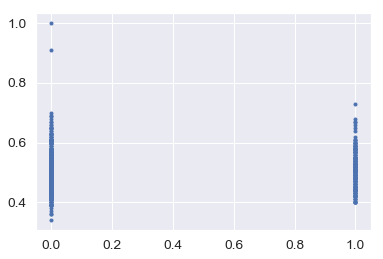

x6


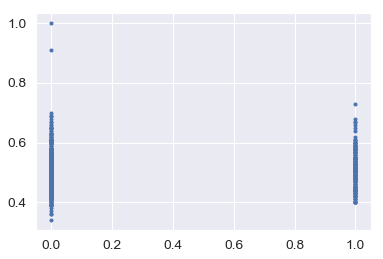

x7


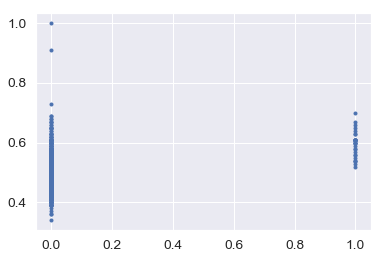

x8


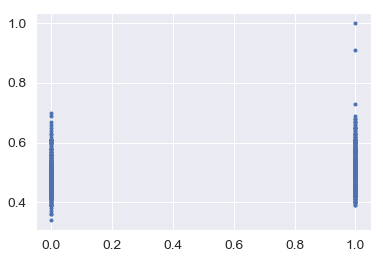

x9


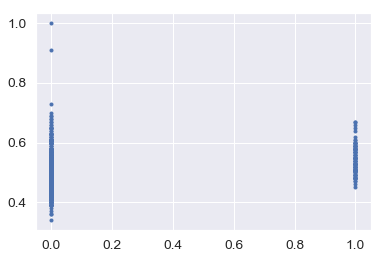

x10


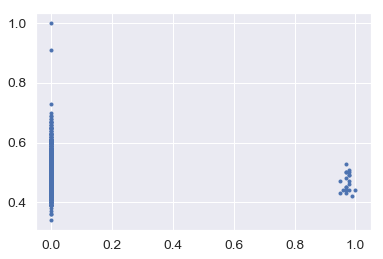

x11


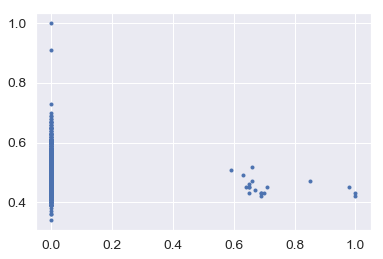

x12


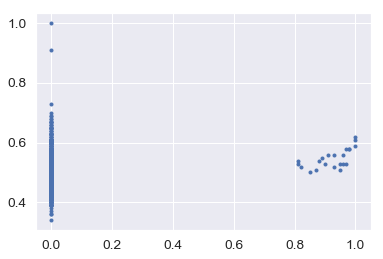

x13


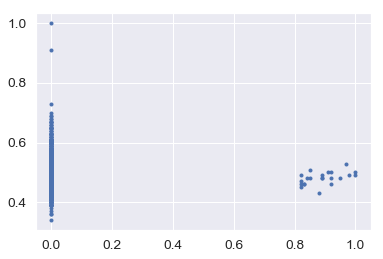

x14


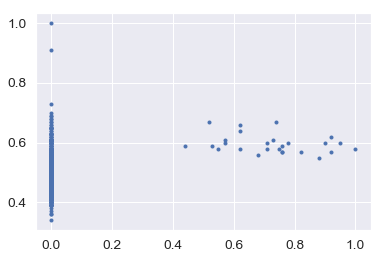

x15


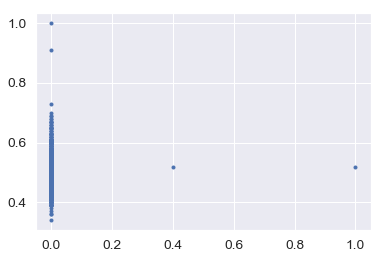

x16


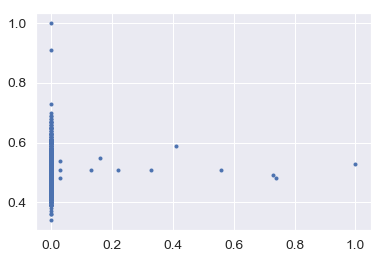

x17


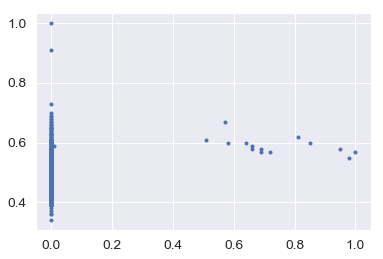

x18


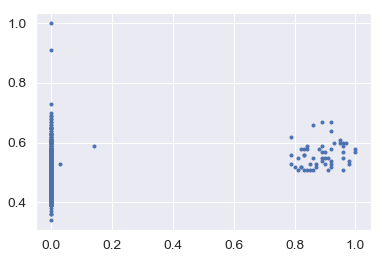

x19


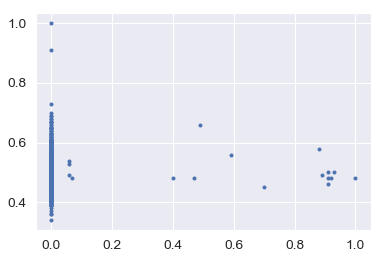

x20


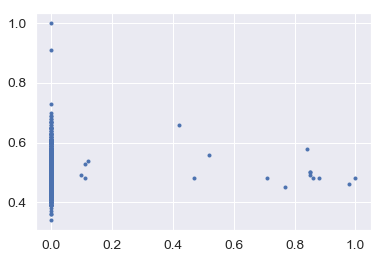

x21


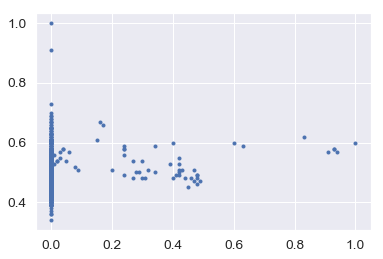

x22


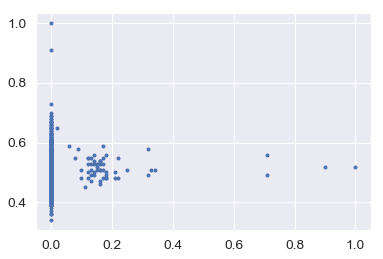

x23


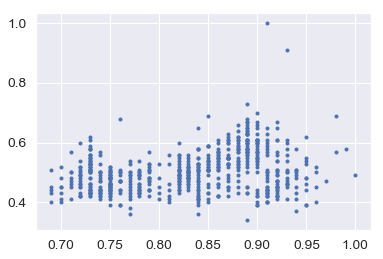

x25


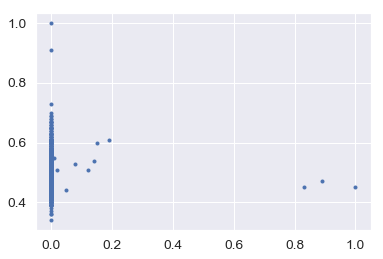

x26


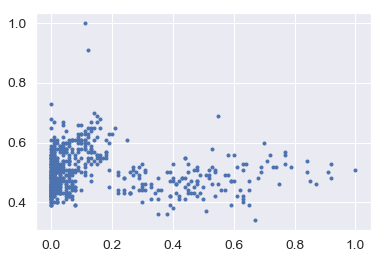

x27


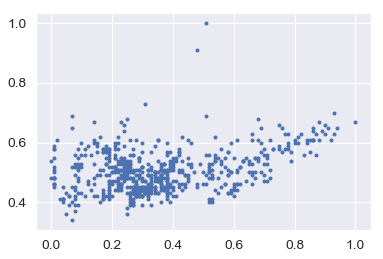

x28


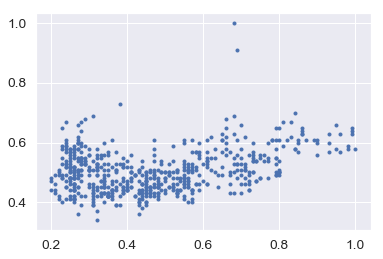

x29


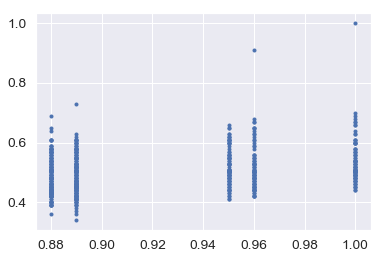

x30


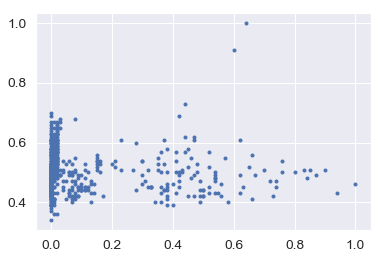

x31


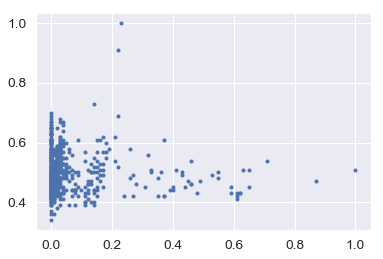

x32


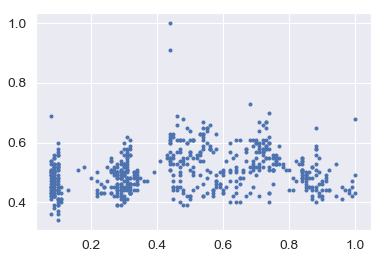

y


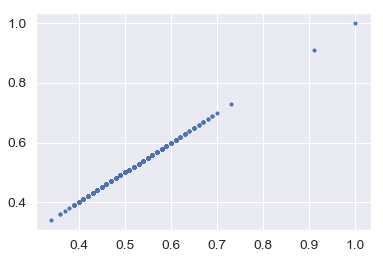

In [23]:
all_col = data.columns
for col in all_col:
    x = data[col]
    print(col)
    plt.plot(x, y, 'b.')
    plt.show()

Интересно, что линейных зависимостей в данных почти нет, однако, есть много условно-дискретных признаков. Для которых, если они не ноль, то на выходе получается некоторое конкретное значение y. С разбросом, конечно.
Это наталкивает на мысль, что деревья будут работать лучше, чем линейная регрессия.

Итак, у нас есть data со всеми признаками. и df_chosen, в которых была попытка отобрать значимые признаки. Так же можно будет попробовать отобрать признаки по результатам подбора коэффициентов линейной регрессии. Которую все-таки тоже попробуем.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import statistics
import math

In [25]:
#данные, конечно, уже выглядят отнормированными, но лишним не будет
scaler = StandardScaler()
x_chosen = scaler.fit_transform(df_chosen, y)
x_full = scaler.fit_transform(data.drop(['y'], axis = 1), y)

In [61]:
grid = {'n_estimators': np.arange(70, 240, 30)}
cv = KFold(n_splits=5, shuffle=True)
gs = GridSearchCV(GradientBoostingRegressor(), grid, scoring='neg_mean_squared_error', cv=cv, verbose=False)

gs.fit(x_full, y)
mse = -np.mean(cross_val_score(gs.best_estimator_, x_full, y=y, cv=cv, scoring='neg_mean_squared_error')) 
#в который раз натыкаюсь и каждый раз недоумеваю. что заставило авторов библиотек сделать mse отрицательным?..
err = math.sqrt(mse)/np.mean(y)*100 #относительная ошибка. корень из дисперсии на среднее.

print(gs.best_params_['n_estimators'], round(err, 3), '%')


220 7.998 %


In [66]:
cv = KFold(n_splits=5, shuffle=True)
print('search for best number of trees')
for n in range(10, 300, 30):

    trees = GradientBoostingRegressor(n_estimators = n)    
    mse = -np.mean(cross_val_score(trees, x_full, y=y, cv=cv, scoring='neg_mean_squared_error')) 
    #в который раз натыкаюсь и каждый раз недоумеваю. что заставило авторов библиотек сделать mse отрицательным?..
    err = math.sqrt(mse)/np.mean(y)*100 #относительная ошибка. корень из дисперсии на среднее.

    print(n, ': ', round(err, 3), '%')

search for best number of trees
10 :  10.433 %
40 :  8.621 %
70 :  8.294 %
100 :  8.323 %
130 :  8.123 %
160 :  7.857 %
190 :  7.766 %
220 :  8.077 %
250 :  7.928 %
280 :  8.931 %


Мало - плохо. (кто бы мог подумать) А дальше более или менее без разницы. Колеблется сильно, но все около 8%

In [67]:
#попробуем на отобранных признаках

v = KFold(n_splits=5, shuffle=True)
print('search for best number of trees')
for n in range(10, 300, 30):

    trees = GradientBoostingRegressor(n_estimators = n)    
    mse = -np.mean(cross_val_score(trees, x_chosen, y=y, cv=cv, scoring='neg_mean_squared_error')) 
    #в который раз натыкаюсь и каждый раз недоумеваю. что заставило авторов библиотек сделать mse отрицательным?..
    err = math.sqrt(mse)/np.mean(y)*100 #относительная ошибка. корень из дисперсии на среднее.

    print(n, ': ', round(err, 3), '%')

search for best number of trees
10 :  11.154 %
40 :  9.745 %
70 :  9.626 %
100 :  8.901 %
130 :  8.855 %
160 :  8.716 %
190 :  8.283 %
220 :  9.14 %
250 :  8.765 %
280 :  8.892 %


Хуже, чем ан полном наборе. Впрочем, деревьям не там важно, есть ли там линейная зависимость признаков.

In [42]:
cv = KFold(n_splits=5, shuffle=True)
print('search for best maximum depth')
for n in range(3, 20):

    trees = GradientBoostingRegressor(n_estimators = 200, max_depth = n)    
    mse = -np.mean(cross_val_score(trees, x_full, y=y, cv=cv, scoring='neg_mean_squared_error')) 
    #в который раз натыкаюсь и каждый раз недоумеваю. что заставило авторов библиотек сделать mse отрицательным?..
    err = math.sqrt(mse)/np.mean(y)*100 #относительная ошибка. корень из дисперсии на среднее.

    print(n, ': ', round(err, 3), '%')


search for best maximum depth
3 :  7.775 %
4 :  7.55 %
5 :  8.984 %
6 :  8.215 %
7 :  8.632 %
8 :  8.297 %
9 :  9.077 %
10 :  9.425 %
11 :  9.86 %
12 :  8.882 %
13 :  9.532 %
14 :  9.803 %
15 :  10.34 %
16 :  10.114 %
17 :  10.172 %
18 :  9.98 %
19 :  10.35 %


Опять же, 3-5 - более или менее одинаково. А вот больше - хуже. 

В любом случае, погрешность ~8% - это, конечно, не блесятще, но гораздо лучше, чем я ожидала, осмотрев графики зависимостей.

In [46]:
#а теперь линейные методы

reg = LinearRegression() 
cv = KFold(n_splits=5, shuffle=True)
mse = -np.mean(cross_val_score(reg, x_full, y=y, cv=cv, scoring='neg_mean_squared_error')) 

err = math.sqrt(mse)/np.mean(y)*100 #относительная ошибка. корень из дисперсии на среднее.

print(round(err, 3), '%')

9.896 %


Действительно немного хуже деревьев. Хотя и незначительно.

На основе обучения линейной регрессии попробуем отобрать наиболее важные признаки и посмотреть, как изменится относительная ошибка.

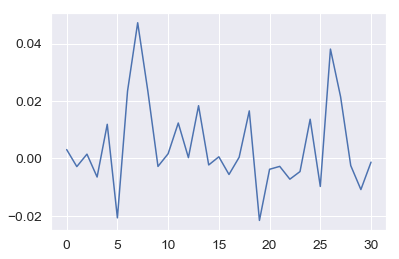

In [47]:
reg.fit(x_full, y)
plt.plot(reg.coef_)
plt.show()

In [50]:
coef = list(data.drop(['y'], axis = 1).dropna().columns)
coef = np.c_[coef, reg.coef_.astype(float)]

coef = pd.DataFrame(data = coef, columns = ['feat', 'coef'])
coef.coef = reg.coef_.astype(float) #почему-то после перевода в df снова стали строками...

In [55]:
new_feat = list(coef.where(coef.coef.abs()>0.01).dropna().feat)
print(new_feat)

['x5', 'x6', 'x7', 'x8', 'x9', 'x12', 'x14', 'x19', 'x20', 'x26', 'x28', 'x29', 'x31']


In [56]:
x_linreg = data[new_feat]

In [57]:
scaler = StandardScaler()
x_linreg = scaler.fit_transform(x_linreg, y)


In [58]:
reg = LinearRegression()
cv = KFold(n_splits=5, shuffle=True)
mse = -np.mean(cross_val_score(reg, x_linreg, y=y, cv=cv, scoring='neg_mean_squared_error'))

err = math.sqrt(mse)/np.mean(y)*100

print(round(err, 3), '%')

9.786 %


Впрочем, как и раньше, получается, что, чем меньше признаков мы оставляем, несмотря на то, что они наиболее существенны, качество ухудшается. И улучшается только при возврате всех признаков на место.

In [59]:
ridge = Ridge(alpha = 0.5)
cv = KFold(n_splits=5, shuffle=True)
mse_ridge_full = -np.mean(cross_val_score(reg, x_full, y=y, cv=cv, scoring='neg_mean_squared_error'))
mse_ridge = -np.mean(cross_val_score(ridge, x_chosen, y=y, cv=cv, scoring='neg_mean_squared_error'))

print(mse_ridge_full, mse_ridge)

0.0024816932112166528 0.0027656439719301942


In [60]:
err_ridge_full = math.sqrt(mse_ridge_full)/np.mean(y)*100
err_ridge = math.sqrt(mse_ridge)/np.mean(y)*100
print(round(err_ridge_full, 3), '%')
print(round(err_ridge, 3), '%')

9.879 %
10.429 %


Так  уже не раз случалось в процессе разбора этой задачки. Если убирать признаки из линейной модели, качество ухудшается. Хотели, как лучше...
Впрочем, деревья все равно лучше, а данные под линейные методы не особо подходят.

In [68]:
est = GradientBoostingRegressor(n_estimators = 200)
est.fit(x_full, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)